# Trabalho Final - Análise e Modelagem para Detecção de Fraude

**Objetivo:** Este notebook cobre as etapas de análise exploratória, pré-processamento e treinamento de um modelo de machine learning para detectar fraudes em transações de cartão de crédito.

**Dataset:** [Credit Card Fraud Detection - Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

**Etapas:**
1.  **Carregamento e Análise Exploratória (EDA):** Entender a estrutura, distribuição e o desbalanceamento dos dados.
2.  **Pré-processamento:** Normalizar as features `Time` e `Amount` e tratar o desbalanceamento com a técnica SMOTE.
3.  **Treinamento do Modelo:** Treinar um modelo XGBoost.
4.  **Avaliação:** Avaliar o modelo com métricas apropriadas (Matriz de Confusão, Precisão, Recall).
5.  **Salvando o Modelo:** Exportar o modelo treinado e o scaler para uso na aplicação final.

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import os

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [2]:
# Carregar o dataset
# O caminho '../data/creditcard.csv' significa "voltar uma pasta e entrar na pasta data"
df = pd.read_csv('../data/creditcard.csv')

# Visualizar informações básicas
print("Shape do dataset:", df.shape)
print("\nExistem valores nulos?", df.isnull().sum().any())
print("\nPrimeiras 5 linhas:")
display(df.head())

Shape do dataset: (284807, 31)

Existem valores nulos? False

Primeiras 5 linhas:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Porcentagem de fraudes: 0.1727%


C:\Users\Owner\AppData\Local\Temp\ipykernel_19372\1847384081.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette=['#3498db', '#e74c3c'])


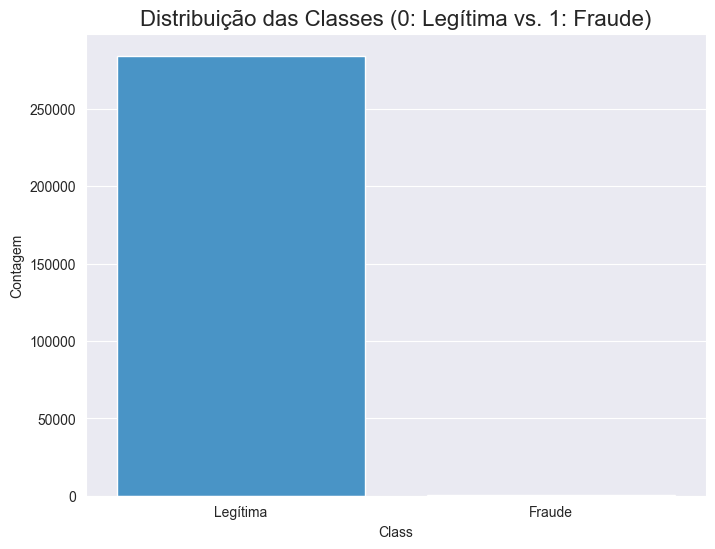

In [3]:
# Contagem e visualização da distribuição das classes
class_counts = df['Class'].value_counts()
fraud_percentage = (class_counts[1] / class_counts.sum()) * 100
print(f"Porcentagem de fraudes: {fraud_percentage:.4f}%")

plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df, palette=['#3498db', '#e74c3c'])
plt.title('Distribuição das Classes (0: Legítima vs. 1: Fraude)', fontsize=16)
plt.xticks([0, 1], ['Legítima', 'Fraude'])
plt.ylabel('Contagem')
plt.show()

In [4]:
# Normalizando 'Time' e 'Amount'
scaler = StandardScaler()
df['scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df_processed = df.drop(['Time', 'Amount'], axis=1)

# Reordenar colunas
cols = [col for col in df_processed.columns if col != 'Class'] + ['Class']
df_processed = df_processed[cols]

print("Dataset após normalização:")
display(df_processed.head())

Dataset após normalização:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,scaled_Amount,scaled_Time,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,-1.996583,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,-1.996583,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,-1.996562,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,-1.996562,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,-1.996541,0


In [5]:
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Dimensões dos conjuntos:", X_train.shape, X_test.shape)

Dimensões dos conjuntos: (199364, 30) (85443, 30)


In [6]:
print("Classes no treino ANTES do SMOTE:", y_train.value_counts().to_dict())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Classes no treino DEPOIS do SMOTE:", y_train_smote.value_counts().to_dict())

Classes no treino ANTES do SMOTE: {0: 199020, 1: 344}
Classes no treino DEPOIS do SMOTE: {0: 199020, 1: 199020}


In [7]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_smote, y_train_smote)
print("Modelo XGBoost treinado com sucesso!")

C:\Users\Owner\PycharmProjects\trabalho-final-ciencia-dados\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:02:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Modelo XGBoost treinado com sucesso!


Relatório de Classificação:

              precision    recall  f1-score   support

Legítima (0)       1.00      1.00      1.00     85295
  Fraude (1)       0.76      0.80      0.78       148

    accuracy                           1.00     85443
   macro avg       0.88      0.90      0.89     85443
weighted avg       1.00      1.00      1.00     85443


Matriz de Confusão:


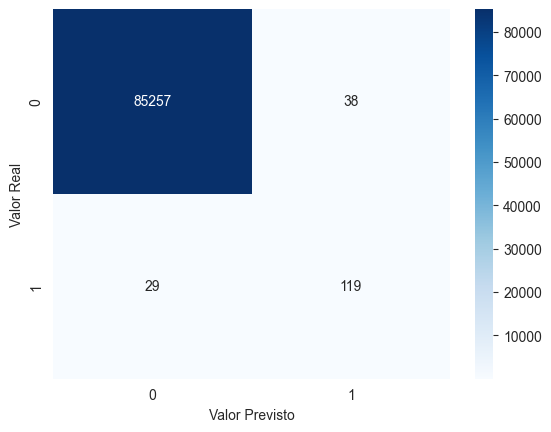

In [8]:
y_pred = model.predict(X_test)

print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred, target_names=['Legítima (0)', 'Fraude (1)']))

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.show()

In [9]:
# Criar a pasta 'models' se ela não existir
output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)

# Salvar o modelo
joblib.dump(model, os.path.join(output_dir, 'fraud_detection_model.pkl'))
print(f"Modelo salvo em: {os.path.join(output_dir, 'fraud_detection_model.pkl')}")

# Salvar o scaler treinado em 'Time' e 'Amount' originais para a aplicação
scaler_for_app = StandardScaler().fit(df[['Time', 'Amount']])
joblib.dump(scaler_for_app, os.path.join(output_dir, 'scaler.pkl'))
print(f"Scaler salvo em: {os.path.join(output_dir, 'scaler.pkl')}")

Modelo salvo em: ../models\fraud_detection_model.pkl
Scaler salvo em: ../models\scaler.pkl
